# Model Development: Titanic-Spaceship <span style="color:orange">**Competition**</span>
<img src="../assets/spaceship-pic.jpg" alt="Title-Pic">

# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import datetime
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})

# Data

In [21]:
MODEL_DATA = np.load("../model_data/titanic_spaceship_prep_data3.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]
DATA_COLUMN_NAMES = MODEL_DATA["input_column_names"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((7004, 9), (876, 9), (876, 9)), ((7004,), (876,), (876,)))

# Helper Functions

In [22]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [23]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [24]:
def print_top_rankings(model, top=10):
    sorted_zipped_report = sorted(
        zip(
            model.cv_results_["params"], 
            model.cv_results_["mean_test_score"], 
            model.cv_results_["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")
        

In [25]:
def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy:\t{f1_score_test}\t|\tTrain-Accuracy:\t{accuracy_score_train}")
    print(f"F1-Score:\t{accuracy_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')


In [26]:
def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

# Build the Model

## Model1: GradientBoost XGB Model

### Basic Model

In [27]:
xgb_model = XGBClassifier(nthread=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

Accuracy:	0.7918457513199606	|	Train-Accuracy:	0.8545117075956596
F1-Score:	0.7922374429223744	|	Train-F1-Score:	0.8538394664912677

              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       441
         1.0       0.76      0.84      0.80       435

    accuracy                           0.79       876
   macro avg       0.80      0.79      0.79       876
weighted avg       0.80      0.79      0.79       876



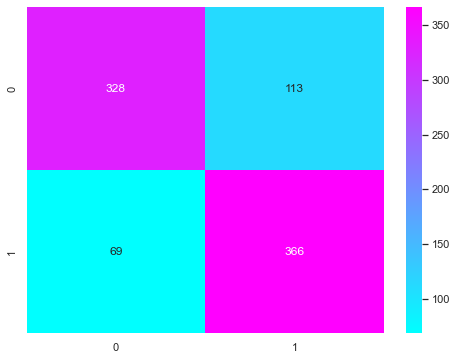

In [28]:
print_model_classification_report(xgb_model, X_test, y_test)

In [29]:
print_feature_importance(xgb_model)

CryoSleep            0.790802
HomePlanet_Earth     0.100939
HomePlanet_Europa    0.035086
VRDeck               0.014397
RoomService          0.014149
Spa                  0.012656
FoodCourt            0.011729
HomePlanet_Mars      0.010776
ShoppingMall         0.009467
dtype: float32

In [30]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': -1}

### GridModel

In [31]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.01, 0.1, 0.25],
    "min_child_weight": [3, 7, 12],
    "n_estimators": [100, 250, 500, 700, 900],
    "eta": [0.05, 0.1],
    "gamma": [1, 4],
    "subsample": [0.6, 0.8],
    "max_depth": [3, 7, 15],
    "colsample_bytree": [0.65, 0.8, 0.95]
}

In [32]:
xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, scoring="accuracy", verbose=3)

xgb_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 3240 candidates, totalling 6480 fits
[CV 1/2] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6;, score=0.780 total time=   0.1s
[CV 2/2] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.6;, score=0.756 total time=   0.1s
[CV 1/2] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.779 total time=   0.1s
[CV 2/2] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.759 total time=   0.1s
[CV 1/2] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=1, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=250, subsample=0.

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.65, 0.8, 0.95],
                         'eta': [0.05, 0.1], 'eval_metric': ['logloss'],
                         'gamma': [1, 4], 'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [3, 7, 15],
                         'min_child_weight': [3, 7, 12],
                         'n_estimators': [100, 250, 500, 700, 900],
                         'subsample': [0.6, 0.8]},
             scoring='accuracy', verbose=3)

Accuracy:	0.7998712805496556	|	Train-Accuracy:	0.7952598515134209
F1-Score:	0.8002283105022832	|	Train-F1-Score:	0.7946425738152995

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       441
         1.0       0.77      0.85      0.81       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



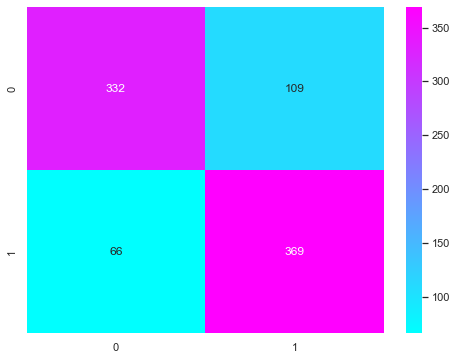

In [35]:
print_model_classification_report(xgb_grid_model, X_test, y_test)

In [37]:
print_top_rankings(xgb_grid_model, 50)

Rank: 1	Score: 0.7851227869788693
Param: {'colsample_bytree': 0.65, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Rank: 1	Score: 0.7851227869788693
Param: {'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'logloss', 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Rank: 3	Score: 0.7842661336379212
Param: {'colsample_bytree': 0.95, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}

Rank: 3	Score: 0.7842661336379212
Param: {'colsample_bytree': 0.95, 'eta': 0.1, 'eval_metric': 'logloss', 'gamma': 4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}

Rank: 5	Score: 0.7839805825242718
Param: {'colsample_bytree': 0.95, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 1, 'le

### Best Model Selection

In [ ]:
xgb_best_model = "err"

## Model2: KNearestNeighbor KNN

### Basic Model

Accuracy:	0.8024905675131468	|	Train-Accuracy:	0.7858366647629925
F1-Score:	0.8025114155251142	|	Train-F1-Score:	0.7858332420077025

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       441
         1.0       0.80      0.80      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



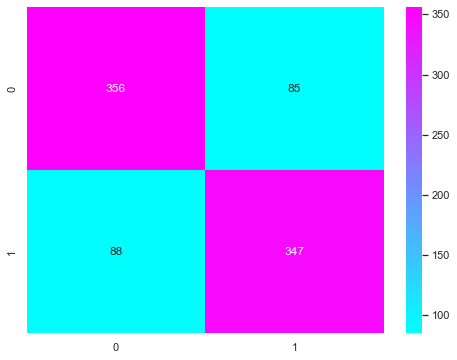

In [38]:
knn_model = KNeighborsClassifier(21) #21 -> 80,249
knn_model.fit(X_train, y_train)
print_model_classification_report(knn_model, X_test, y_test)

### GridModel

In [39]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(3, 50, 1),
    "metric": ["manhattan", "euclidean"],
    "weights": ["distance"]
}

In [40]:
knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=2, scoring="accuracy", verbose=3)

knn_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 94 candidates, totalling 188 fits
[CV 1/2] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.688 total time=   0.0s
[CV 2/2] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.743 total time=   0.0s
[CV 1/2] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.691 total time=   0.0s
[CV 2/2] END metric=manhattan, n_neighbors=4, weights=distance;, score=0.735 total time=   0.0s
[CV 1/2] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.713 total time=   0.0s
[CV 2/2] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.750 total time=   0.0s
[CV 1/2] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.716 total time=   0.0s
[CV 2/2] END metric=manhattan, n_neighbors=6, weights=distance;, score=0.751 total time=   0.0s
[CV 1/2] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.719 total time=   0.0s
[CV 2/2] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.7

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['distance']},
             scoring='accuracy', verbose=3)

Accuracy:	0.7979006969435889	|	Train-Accuracy:	0.9070531125071388
F1-Score:	0.797945205479452	|	Train-F1-Score:	0.9067504908039511

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       441
         1.0       0.80      0.79      0.79       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



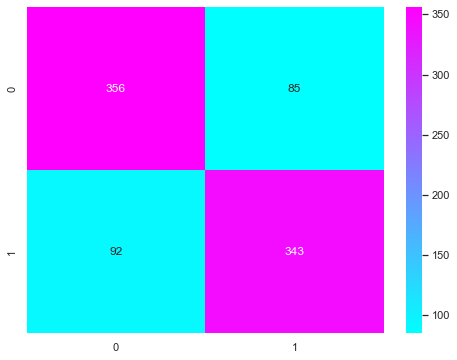

In [41]:
print_model_classification_report(knn_grid_model, X_test, y_test)

In [42]:
print_top_rankings(knn_grid_model, 20)

Rank: 1	Score: 0.7764134780125642
Param: {'metric': 'manhattan', 'n_neighbors': 48, 'weights': 'distance'}

Rank: 2	Score: 0.7756996002284409
Param: {'metric': 'manhattan', 'n_neighbors': 46, 'weights': 'distance'}

Rank: 3	Score: 0.7755568246716162
Param: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}

Rank: 4	Score: 0.7754140491147916
Param: {'metric': 'manhattan', 'n_neighbors': 43, 'weights': 'distance'}

Rank: 5	Score: 0.7752712735579669
Param: {'metric': 'manhattan', 'n_neighbors': 41, 'weights': 'distance'}

Rank: 5	Score: 0.7752712735579669
Param: {'metric': 'manhattan', 'n_neighbors': 42, 'weights': 'distance'}

Rank: 7	Score: 0.7751284980011423
Param: {'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance'}

Rank: 8	Score: 0.7751284980011421
Param: {'metric': 'manhattan', 'n_neighbors': 44, 'weights': 'distance'}

Rank: 9	Score: 0.7749857224443175
Param: {'metric': 'manhattan', 'n_neighbors': 36, 'weights': 'distance'}

Rank: 10	Score: 0.7748429468

### Best Model Selection

In [ ]:
knn_best_model = "err"

## Model3: RandomForest

### Basic Model

Accuracy:	0.812432435255349	|	Train-Accuracy:	0.9073386636207881
F1-Score:	0.8127853881278538	|	Train-F1-Score:	0.906490627135635

              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80       441
         1.0       0.78      0.86      0.82       435

    accuracy                           0.81       876
   macro avg       0.82      0.81      0.81       876
weighted avg       0.82      0.81      0.81       876



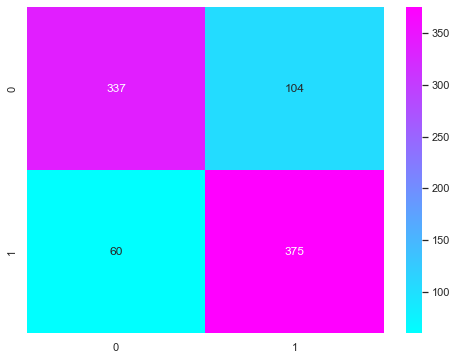

In [84]:
rf_model = RandomForestClassifier(n_estimators=320, random_state=101) # 320 -> 81.24
rf_model.fit(X_train, y_train)
print_model_classification_report(rf_model, X_test, y_test)

### GridModel

In [43]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": [10, 20, 50, 90, 150],
    "min_samples_split": [3, 7, 10],
    "min_samples_leaf": [2, 6, 9],

    # BaggingClassifier params
    "n_estimators": [100, 320, 550, 700, 900],
    "max_samples": [0.8, 0.95],
    "bootstrap": [True]
}

In [44]:
rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="accuracy", verbose=3)

rf_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 450 candidates, totalling 900 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.786 total time=   0.2s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.776 total time=   0.2s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=320;, score=0.789 total time=   0.5s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=320;, score=0.776 total time=   0.5s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=550;, score=0.789 total time=   0.9s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=10, max_samples=0.8, min_samples_leaf=2, min_sa

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10, 20, 50, 90, 150],
                         'max_samples': [0.8, 0.95],
                         'min_samples_leaf': [2, 6, 9],
                         'min_samples_split': [3, 7, 10],
                         'n_estimators': [100, 320, 550, 700, 900]},
             scoring='accuracy', verbose=3)

Accuracy:	0.8012445037893211	|	Train-Accuracy:	0.8126784694460308
F1-Score:	0.8013698630136986	|	Train-F1-Score:	0.8122566287210146

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80       441
         1.0       0.78      0.83      0.81       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



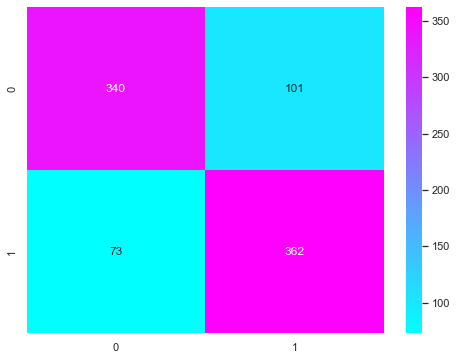

In [45]:
print_model_classification_report(rf_grid_model, X_test, y_test)

In [46]:
print_top_rankings(rf_grid_model, 20)

Rank: 1	Score: 0.7836950314106225
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.8, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 100}

Rank: 2	Score: 0.7834094802969731
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700}

Rank: 3	Score: 0.7831239291833239
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_samples': 0.95, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 320}

Rank: 3	Score: 0.7831239291833239
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700}

Rank: 5	Score: 0.7829811536264992
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 320}

Rank: 5	Score: 0.7829811536264992
Param: {'bootstrap': 

### Best Model Selection

In [ ]:
rf_best_model = "err"

## Model4 - Support Vector Machine SVM

### Basic Model

Accuracy:	0.8000654710590531	|	Train-Accuracy:	0.7888349514563107
F1-Score:	0.8002283105022832	|	Train-F1-Score:	0.7883391043866101

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       441
         1.0       0.78      0.83      0.81       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876



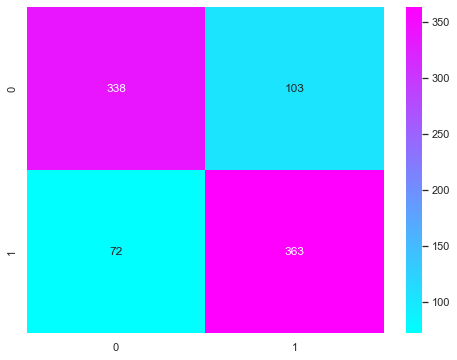

In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
print_model_classification_report(svm_model, X_test, y_test)

### GridModel

In [51]:
svm_tmp_model = SVC(probability=True)

svm_grid_params = {
    "C": [5, 1, 0.5, 0.001],
    "gamma": ["auto", "scale"],
    "kernel": ["poly", "rbf"],
    "degree": [3, 4, 5, 6],
    "coef0": [1, 0.8, 1.2]
}

In [52]:
svm_grid_model = GridSearchCV(svm_tmp_model, svm_grid_params, cv=2, scoring="accuracy", verbose=3)

svm_grid_model.fit(X_train, y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[CV 1/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.784 total time=   1.1s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=poly;, score=0.777 total time=   1.1s
[CV 1/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=rbf;, score=0.784 total time=   0.9s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=auto, kernel=rbf;, score=0.778 total time=   0.9s
[CV 1/2] END C=5, coef0=1, degree=3, gamma=scale, kernel=poly;, score=0.786 total time=   1.6s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=scale, kernel=poly;, score=0.776 total time=   1.8s
[CV 1/2] END C=5, coef0=1, degree=3, gamma=scale, kernel=rbf;, score=0.787 total time=   1.0s
[CV 2/2] END C=5, coef0=1, degree=3, gamma=scale, kernel=rbf;, score=0.777 total time=   0.9s
[CV 1/2] END C=5, coef0=1, degree=4, gamma=auto, kernel=poly;, score=0.787 total time=   1.4s
[CV 2/2] END C=5, coef0=1, degree=4, gamma=auto, kernel=poly;, score=0.776 total time=   1.

GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [5, 1, 0.5, 0.001], 'coef0': [1, 0.8, 1.2],
                         'degree': [3, 4, 5, 6], 'gamma': ['auto', 'scale'],
                         'kernel': ['poly', 'rbf']},
             scoring='accuracy', verbose=3)

Accuracy:	0.8059320266889074	|	Train-Accuracy:	0.7949743003997716
F1-Score:	0.8059360730593608	|	Train-F1-Score:	0.7949560932290568

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       441
         1.0       0.80      0.81      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876



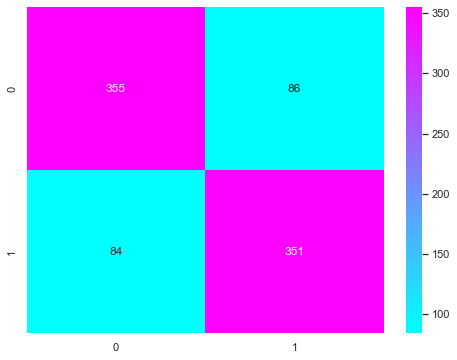

In [53]:
print_model_classification_report(svm_grid_model, X_test, y_test)

In [54]:
print_top_rankings(svm_grid_model, 20)

Rank: 1	Score: 0.7824100513992005
Param: {'C': 1, 'coef0': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 1, 'degree': 6, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 0.8, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 0.8, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 0.8, 'degree': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Rank: 2	Score: 0.7822672758423759
Param: {'C': 5, 'coef0': 0.8, 'degree': 6, 'gamma': 'scale', 'kernel': 

### Best Model Selection

In [ ]:
svm_best_model = "err"

## Model5 - DecisionTree

### Basic Model

Accuracy:	0.7628624293013182	|	Train-Accuracy:	0.9073386636207881
F1-Score:	0.7648401826484018	|	Train-F1-Score:	0.9064957513805084

              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       441
         1.0       0.72      0.86      0.78       435

    accuracy                           0.76       876
   macro avg       0.78      0.77      0.76       876
weighted avg       0.78      0.76      0.76       876



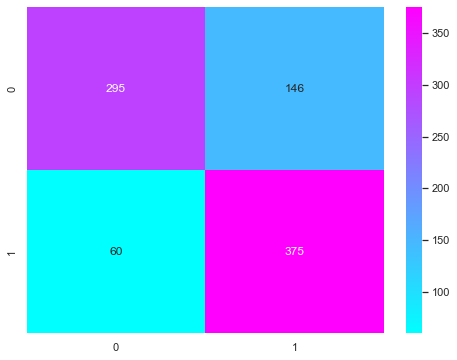

In [98]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
print_model_classification_report(dt_model, X_test, y_test)

In [ ]:
dt_best_model = dt_model

## Model6 - EnsembleModel1 -> VotingClassifier

In [99]:
estimators_c1 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
    ("svm", svm_model),
    ("dt", dt_model)
]

estimators_c2 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model),
    ("svm", svm_model)
]

estimators_c3 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("svm", svm_model)
]

estimators_c4 = [
    ("rf", rf_model),
    ("knn", knn_model),
    ("xgb", xgb_model)
]

estimators_c5 = [
    ("rf", rf_model),
    ("knn", knn_model)
]

In [105]:
vc_model1 = VotingClassifier(estimators=estimators_c1, voting="soft")
vc_model2 = VotingClassifier(estimators=estimators_c2, voting="soft")
vc_model3 = VotingClassifier(estimators=estimators_c3, voting="soft")
vc_model4 = VotingClassifier(estimators=estimators_c4, voting="soft")
vc_model5 = VotingClassifier(estimators=estimators_c5, voting="soft")

vc_model1.fit(X_train, y_train)
vc_model2.fit(X_train, y_train)
vc_model3.fit(X_train, y_train)
vc_model4.fit(X_train, y_train)
vc_model5.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=320,
                                                     random_state=101)),
                             ('knn', KNeighborsClassifier(n_neighbors=21))],
                 voting='soft')

Accuracy:	0.8025090992966859	|	Train-Accuracy:	0.8823529411764706
F1-Score:	0.8025114155251142	|	Train-F1-Score:	0.8822214775701687

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       441
         1.0       0.80      0.81      0.80       435

    accuracy                           0.80       876
   macro avg       0.80      0.80      0.80       876
weighted avg       0.80      0.80      0.80       876

Accuracy:	0.8082101806239737	|	Train-Accuracy:	0.8395202741290692
F1-Score:	0.8082191780821918	|	Train-F1-Score:	0.8394777483115844

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       441
         1.0       0.81      0.81      0.81       435

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.8093545196396434	|	Train-Accuracy:	0.8306681896059395
F1-Score:	0.80

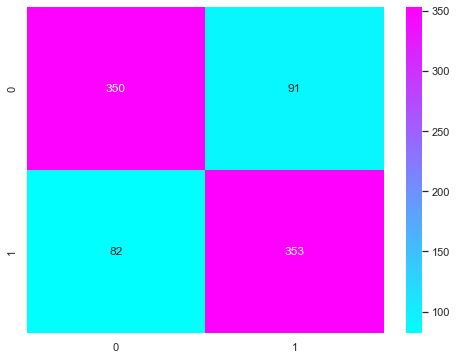

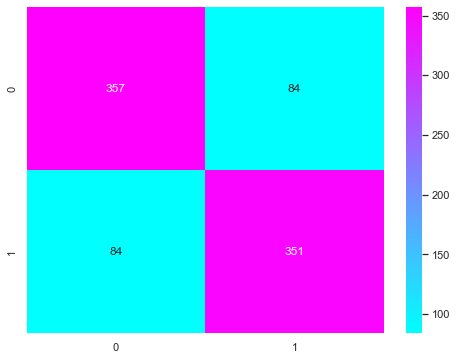

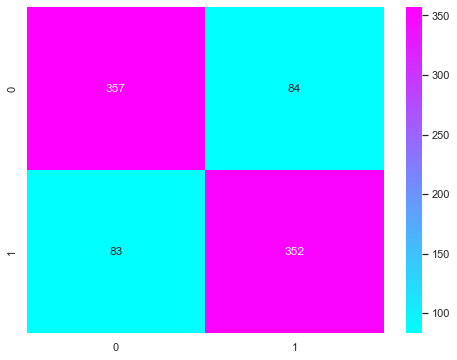

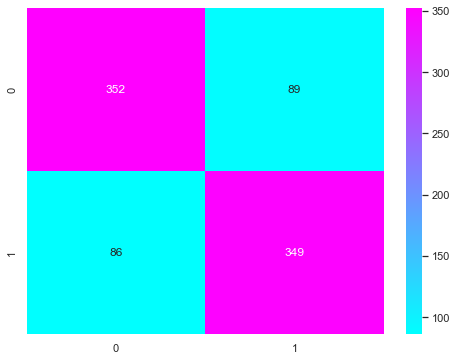

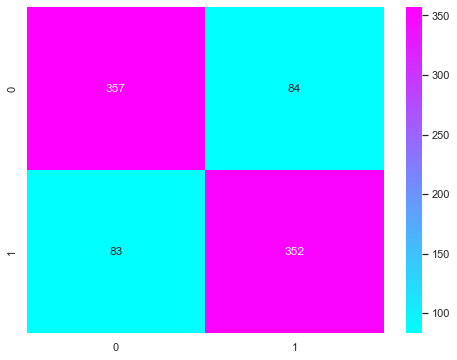

In [106]:
print_model_classification_report(vc_model1, X_test, y_test)
print_model_classification_report(vc_model2, X_test, y_test)
print_model_classification_report(vc_model3, X_test, y_test)
print_model_classification_report(vc_model4, X_test, y_test)
print_model_classification_report(vc_model5, X_test, y_test)

In [59]:
grid_estimators_c1 = [
    ("svm", svm_grid_model.best_estimator_),
    ("rf", rf_grid_model.best_estimator_),
    ("xgb", xgb_grid_model.best_estimator_),
    ("knn", knn_grid_model.best_estimator_),
]

grid_estimators_c2 = [
    ("rf", rf_grid_model.best_estimator_),
    ("svm", svm_grid_model.best_estimator_),
    ("knn", knn_grid_model.best_estimator_),
]

grid_estimators_c3 = [
    ("svm", svm_grid_model.best_estimator_),
    ("rf", rf_grid_model.best_estimator_),
    ("xgb", xgb_grid_model.best_estimator_),
]

In [60]:
vc_grid_model1 = VotingClassifier(estimators=grid_estimators_c1, voting="soft")
vc_grid_model2 = VotingClassifier(estimators=grid_estimators_c2, voting="soft")
vc_grid_model3 = VotingClassifier(estimators=grid_estimators_c3, voting="soft")

vc_grid_model1.fit(X_train, y_train)
vc_grid_model2.fit(X_train, y_train)
vc_grid_model3.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(C=1, coef0=1, degree=4, kernel='poly',
                                  probability=True)),
                             ('rf',
                              RandomForestClassifier(max_depth=90,
                                                     max_samples=0.8,
                                                     min_samples_leaf=9,
                                                     min_samples_split=10)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.65,
                                            early_stopping_rounds=None,...
                                            eval_metric='logloss', gamma=4,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=3,
                                            max_leaves=0, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=-1,
                                            nthread=-1, num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...))],
                 voting='soft')

Accuracy:	0.8093604821632188	|	Train-Accuracy:	0.8536550542547116
F1-Score:	0.8093607305936074	|	Train-F1-Score:	0.8536269797419422

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       444
         1.0       0.80      0.82      0.81       432

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.8070753628967626	|	Train-Accuracy:	0.8717875499714449
F1-Score:	0.8070776255707762	|	Train-F1-Score:	0.8717009188278815

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       444
         1.0       0.80      0.81      0.81       432

    accuracy                           0.81       876
   macro avg       0.81      0.81      0.81       876
weighted avg       0.81      0.81      0.81       876

Accuracy:	0.8082181784063011	|	Train-Accuracy:	0.8008280982295831
F1-Score:	0.80

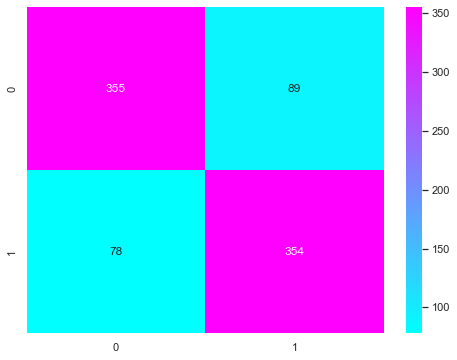

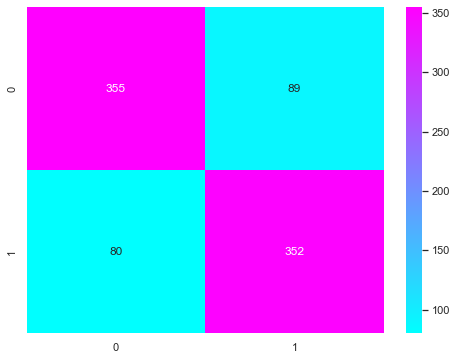

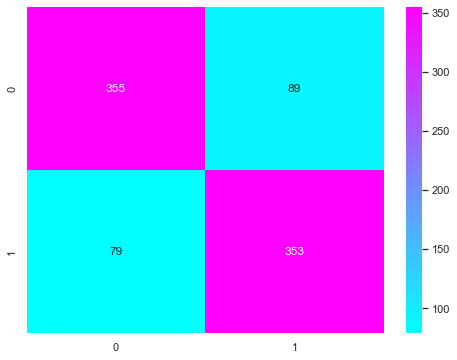

In [63]:
print_model_classification_report(vc_grid_model1, X_val, y_val)
print_model_classification_report(vc_grid_model2, X_val, y_val)
print_model_classification_report(vc_grid_model3, X_val, y_val)

80.93%

# Final Model Selection

# Create Submissions

In [75]:
def get_submission_csv_df(model, test_data_path):
    df_test_data = pd.read_csv(test_data_path)
    preds = Series(model.predict(df_test_data.drop(columns=["PassengerId"]).to_numpy())).map({0: False, 1: True})
    return DataFrame({"PassengerId": df_test_3["PassengerId"], "Transported": preds})

def save_submissions(df, csv_name):
    df.to_csv(f"../submissions/{csv_name}.csv", index=False)

In [67]:
df_test_3 = 
df_test_3

,PassengerId,CryoSleep,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0013_01,1,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,1,0,0
1,0018_01,0,-0.640372,0.136898,-0.624889,2.212364,-0.634810,1,0,0
2,0019_01,1,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,0,1,0
3,0021_01,0,-0.640372,2.355227,-0.624889,1.220078,1.692465,0,1,0
4,0023_01,0,0.240591,-0.648903,1.883712,-0.663234,-0.634810,1,0,0
...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,1,0,0
4273,9269_01,0,-0.640372,1.652233,0.498359,0.204556,1.182489,1,0,0
4274,9271_01,1,-0.640372,-0.648903,-0.624889,-0.663234,-0.634810,0,0,1
4275,9273_01,0,-0.640372,2.045055,-0.624889,-0.663234,1.651630,0,1,0


In [78]:
TEST_PATH = "../model_data/submission_test_data3.csv"

In [76]:
submission1 = get_submission_csv_df(vc_grid_model2, "../model_data/submission_test_data3.csv")
submission1

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [77]:
save_submissions(submission1, "vc_grid_model2")

In [79]:
submission2 = get_submission_csv_df(vc_grid_model1, TEST_PATH)
submission2

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [80]:
save_submissions(submission2, "vc_grid_model1")

In [81]:
submission3 = get_submission_csv_df(svm_grid_model.best_estimator_, TEST_PATH)
submission3

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [82]:
save_submissions(submission3, "svm")


In [85]:
submission4 = get_submission_csv_df(rf_model, TEST_PATH)
submission4

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [86]:
save_submissions(submission3, "rf")


# Export the Model

In [ ]:
rf_model